# Visual QA, Coeus
<center><img src='https://imgur.com/vpMkNww.jpg'></center>
Project for the deep learning course 2021/2022 held by professor Fabrizio Silvestri. 

Since the choosen task is about **Visual Question Answering** we've picked a mythical and distinctive name for the project, ***COEUS***. 


> ⚡ In Greek mythology, Coeus (*from Ancient Greek: Κοῖος, Koios, "query, questioning" or "intelligence"*)  was one of the Titans.

## Colab integration

We produced the code using a local environment in vscode. To make it works with colab, after cloning the github repository, we also had to reduce the size of the dataset (10000->7000, or we must buy colab-pro for higher ram), reduce the number of workers (8->2) and remove the "pin memory" property of the dataloader (True->False).

In [1]:
local_project = True
if not local_project:
    !git clone https://github.com/DennisRotondi/Visual_QA_deep_learning
    !pip3 install -r Visual_QA_deep_learning/requirements.txt
    %cd Visual_QA_deep_learning/datasets
    !bash download_dataset.sh
    !rm *.zip
    #we restart the runtime to load the new libraries
    exit()

In [2]:
# after exiting the runtime is roleaded and we need to re-define this variable
local_project = True
# this is the last thing to do, it allows to have coherent relative paths wrt the local env 
%cd Visual_QA_deep_learning

[Errno 2] No such file or directory: 'Visual_QA_deep_learning'
/home/dennis/Desktop/Visual_QA_deep_learning


## Import and reproducibility stuff

In [3]:
import copy
import csv
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pytorch_lightning as pl
import random
import re
import torch
import torch.nn.functional as F
from PIL import Image
from collections import OrderedDict, Counter
from dataclasses import dataclass, asdict
from os import path
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from torch import nn, optim
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torchvision import transforms
from tqdm import tqdm
from transformers import ViltProcessor, ViltForQuestionAnswering, ViltModel
from typing import Tuple, List, Any, Dict, Optional
os.environ['TOKENIZERS_PARALLELISM'] = "false" # to avoid deadlock at traning time for the tokenizer
# it's important to have reproducible experiment, to this purpose we seeded everything is seedable
np.random.seed(0)
random.seed(0)
torch.cuda.manual_seed(0)
torch.manual_seed(0)
# Note that this Deterministic mode can have a performance impact
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
_ = pl.seed_everything(0)


Global seed set to 0


## Data Preprocessing

The first step is to read and preprocess the dataset. The input has been processed accordingly to the following rules:

*   Making all characters lowercase;
*   Removing periods except if it occurs as decimal;
*   Converting number words to digits;
*   Removing articles (*a*, *an*, *the*);
*   Adding apostrophe if a contraction is missing it (e.g., convert *”dont”* to *”don’t”*);
*   Replacing all punctuation (except *apostrophe* and *colon*) with a space character.

In such a way it's also possible to have an utility to preprocess sentences when complex solution that produce "not processed" words is engaged. <br> 
Note that those steps are required at evaluation time to compute the correct metric!

In [4]:
# this code comes partially from the original implementation https://github.com/GT-Vision-Lab/VQA,
# it helps in reading the json files from the dataset and creating a class to quickly retrieve the
# annotations of each <question, image> pair. Here we also perform the preprocessing needed for
# evaluation, these changes affect the vocabularies (using more advanced embeddings like bert-uncased
# is very useful to have "uncased" words for example),
class VQA:
	def __init__(self, annotations_file: str, questions_file: str, images_semi_path: str, remove_mult_ans: bool, limit_size: int):
		self.proprocess_init()
		# we load the answer and the question json file
		dataset = json.load(open(annotations_file, 'r'))
		questions = json.load(open(questions_file, 'r'))
		# 'qa' and 'qqa' will be the dictionaries where the output of the preprocessing step will be saved!
		qa = dict()
		qqa = dict()
		# total number of questions
		self.n_tot = 0
		# number of answers with more than a word
		self.n_mul = 0
		# counter for the length of each answer, to understand if a baseline that produce one-word ans is feasible
		self.c_len = Counter()
		###############################  PREPROCESSING  ####################################
		for ann in dataset['annotations']:
			self.n_tot += 1
			if self.n_tot > limit_size:
				break
			qid = ann['question_id']
			qatmp = ann
			qatmp["multiple_choice_answer"] = self.preprocess(
				qatmp["multiple_choice_answer"])
			ln = len(qatmp["multiple_choice_answer"].split())
			self.c_len.update([ln])
			if ln > 1:
				self.n_mul += 1
				if remove_mult_ans:
					continue
			qa[qid] = qatmp
			for i in range(10):
				qa[qid]["answers"][i]["answer"] = self.preprocess(
					qa[qid]["answers"][i]["answer"])
		for ques in questions['questions']:
			qid = ques['question_id']
			if qa.get(qid, "N") == "N":
				continue
			qqa[qid] = ques
			qqa[qid]["question"] = self.preprocess(qqa[qid]["question"])
		#######################################################################################
		self.qa = qa
		self.qqa = qqa
		self.images_semi_path = images_semi_path

	def get_img_from_id(self, img_id):
		ids = str(img_id)
		# small trick to retrive the path from the id
		return self.images_semi_path+"0"*(12-len(ids))+ids+".jpg"

	def proprocess_init(self):
		# this function just set the utilities for the preprocessing
		self.contractions = {"aint": "ain't", "arent": "aren't", "cant": "can't", "couldve": "could've", "couldnt": "couldn't",
						"couldn'tve": "couldn't've", "couldnt've": "couldn't've", "didnt": "didn't", "doesnt": "doesn't", "dont": "don't", "hadnt": "hadn't",
						"hadnt've": "hadn't've", "hadn'tve": "hadn't've", "hasnt": "hasn't", "havent": "haven't", "hed": "he'd", "hed've": "he'd've",
						"he'dve": "he'd've", "hes": "he's", "howd": "how'd", "howll": "how'll", "hows": "how's", "Id've": "I'd've", "I'dve": "I'd've",
						"Im": "I'm", "Ive": "I've", "isnt": "isn't", "itd": "it'd", "itd've": "it'd've", "it'dve": "it'd've", "itll": "it'll", "let's": "let's",
						"maam": "ma'am", "mightnt": "mightn't", "mightnt've": "mightn't've", "mightn'tve": "mightn't've", "mightve": "might've",
						"mustnt": "mustn't", "mustve": "must've", "neednt": "needn't", "notve": "not've", "oclock": "o'clock", "oughtnt": "oughtn't",
						"ow's'at": "'ow's'at", "'ows'at": "'ow's'at", "'ow'sat": "'ow's'at", "shant": "shan't", "shed've": "she'd've", "she'dve": "she'd've",
						"she's": "she's", "shouldve": "should've", "shouldnt": "shouldn't", "shouldnt've": "shouldn't've", "shouldn'tve": "shouldn't've",
						"somebody'd": "somebodyd", "somebodyd've": "somebody'd've", "somebody'dve": "somebody'd've", "somebodyll": "somebody'll",
						"somebodys": "somebody's", "someoned": "someone'd", "someoned've": "someone'd've", "someone'dve": "someone'd've",
						"someonell": "someone'll", "someones": "someone's", "somethingd": "something'd", "somethingd've": "something'd've",
						"something'dve": "something'd've", "somethingll": "something'll", "thats": "that's", "thered": "there'd", "thered've": "there'd've",
						"there'dve": "there'd've", "therere": "there're", "theres": "there's", "theyd": "they'd", "theyd've": "they'd've",
						"they'dve": "they'd've", "theyll": "they'll", "theyre": "they're", "theyve": "they've", "twas": "'twas", "wasnt": "wasn't",
						"wed've": "we'd've", "we'dve": "we'd've", "weve": "we've", "werent": "weren't", "whatll": "what'll", "whatre": "what're",
						"whats": "what's", "whatve": "what've", "whens": "when's", "whered": "where'd", "wheres": "where's", "whereve": "where've",
						"whod": "who'd", "whod've": "who'd've", "who'dve": "who'd've", "wholl": "who'll", "whos": "who's", "whove": "who've", "whyll": "why'll",
						"whyre": "why're", "whys": "why's", "wont": "won't", "wouldve": "would've", "wouldnt": "wouldn't", "wouldnt've": "wouldn't've",
						"wouldn'tve": "wouldn't've", "yall": "y'all", "yall'll": "y'all'll", "y'allll": "y'all'll", "yall'd've": "y'all'd've",
						"y'alld've": "y'all'd've", "y'all'dve": "y'all'd've", "youd": "you'd", "youd've": "you'd've", "you'dve": "you'd've",
						"youll": "you'll", "youre": "you're", "youve": "you've"}
		self.manualMap = {'none': '0',
					'zero': '0',
					'one': '1',
					'two': '2',
					'three': '3',
					'four': '4',
					'five': '5',
					'six': '6',
					'seven': '7',
					'eight': '8',
					'nine': '9',
					'ten': '10'
					}
		self.articles = ['a', 'an', 'the']
		self.periodStrip = re.compile("(?!<=\d)(\.)(?!\d)")
		self.commaStrip = re.compile("(\d)(\,)(\d)")
		self.punct = [';', r"/", '[', ']', '"', '{', '}',
						'(', ')', '=', '+', '\\', '_', '-',
						'>', '<', '@', '`', ',', '?', '!']

	def preprocess(self, sentence):
		sentence = sentence.lower()
		sentence = sentence.replace('\n', ' ')
		sentence = sentence.replace('\t', ' ')
		sentence = sentence.strip()
		ls = sentence.split()
		ws = []
		for w in ls:
			w = self.processPunctuation(w)
			w = self.processDigitArticle(w)
			ws += [w]
		return " ".join(ws)

	def processPunctuation(self, inText):
		outText = inText
		for p in self.punct:
			if (p + ' ' in inText or ' ' + p in inText) or (re.search(self.commaStrip, inText) != None):
				outText = outText.replace(p, '')
			else:
				outText = outText.replace(p, ' ')
		outText = self.periodStrip.sub("",
                                 outText,
                                 re.UNICODE)
		return outText

	def processDigitArticle(self, inText):
		outText = []
		tempText = inText.lower().split()
		for word in tempText:
			word = self.manualMap.setdefault(word, word)
			if word not in self.articles:
				outText.append(word)
			else:
				pass
		for wordId, word in enumerate(outText):
			if word in self.contractions:
				outText[wordId] = self.contractions[word]
		outText = ' '.join(outText)
		return outText


# Input json files for the VQA class
annotations_file = "datasets/v2_mscoco_train2014_annotations.json"
questions_file = "datasets/v2_OpenEnded_mscoco_train2014_questions.json"
images_semi_path = "datasets/train2014/COCO_train2014_"  # 000000000009.jpg
# We give as input the semi path to the train images:
# in this way we are able to easily retrieve the images thanks to the class function "get_img_from_id"
# NOTE: we cannot use the whole dataset as it is with our limited hardware, therefore we limited 
# ourselves fixing a size of 10000 samples (on the local probject).
train_VQA = VQA(annotations_file, questions_file,
                images_semi_path, remove_mult_ans=True, limit_size=10000)

# We also require to load the validation annotations and images, it will be useful later to test our models
# NOTE: here we can't remove "mult_ans" since it would be like cheating during the evaluation
annotations_file_val = "datasets/v2_mscoco_val2014_annotations.json"
questions_file_val = "datasets/v2_OpenEnded_mscoco_val2014_questions.json"
images_semi_path_val = "datasets/val2014/COCO_val2014_"
val_VQA = VQA(annotations_file_val, questions_file_val, images_semi_path_val, remove_mult_ans=False, limit_size=1000)


### View data


Lets visualize the structure of our data, it would be useful to access correctly the different fields.

#### Answer sample

In [5]:
# For example for the question id '309002'
train_VQA.qa[309002]

{'question_type': 'what animal is',
 'multiple_choice_answer': 'dog',
 'answers': [{'answer': 'bear', 'answer_confidence': 'yes', 'answer_id': 1},
  {'answer': 'dog', 'answer_confidence': 'yes', 'answer_id': 2},
  {'answer': 'dog', 'answer_confidence': 'yes', 'answer_id': 3},
  {'answer': 'bear', 'answer_confidence': 'yes', 'answer_id': 4},
  {'answer': 'dog', 'answer_confidence': 'maybe', 'answer_id': 5},
  {'answer': 'dog', 'answer_confidence': 'yes', 'answer_id': 6},
  {'answer': 'dog', 'answer_confidence': 'yes', 'answer_id': 7},
  {'answer': 'dog', 'answer_confidence': 'yes', 'answer_id': 8},
  {'answer': 'teddy bear', 'answer_confidence': 'yes', 'answer_id': 9},
  {'answer': 'dog', 'answer_confidence': 'yes', 'answer_id': 10}],
 'image_id': 309,
 'answer_type': 'other',
 'question_id': 309002}

#### Question sample

In [6]:
# For example for the question id '309002'
train_VQA.qqa[309002]

{'image_id': 309, 'question': 'what animal is shown', 'question_id': 309002}

#### Image + question + answer

The complete sample needed for our Visual QA task.

QUESTION ID: 131366000

datasets/train2014/COCO_train2014_000000131366.jpg



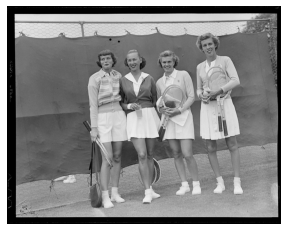

QUESTION
how many people are standing next to each other
MOST COMMON ANSWER
4


In [7]:
# let's see if it works
q = 131366000
print("QUESTION ID: {}".format(q))
print()
img_id = train_VQA.qqa[q]["image_id"]
img_pth = train_VQA.get_img_from_id(img_id)
print(img_pth)
print()

img = Image.open(img_pth).convert('RGB')
plt.imshow(img)
plt.axis('off')
plt.show()
print("QUESTION")
print(train_VQA.qqa[q]["question"])
print("MOST COMMON ANSWER")
print(train_VQA.qa[q]["multiple_choice_answer"])


## Vocabulary
We need a data structure to encode and decode the words we are going to feed up our Deep Learning Model, this structure is the vocabulary under the form of a python dictionry.
We've built a vocabulary of size **1000** with two extra tokens which are used for: **OOV** (*out of vocabulary*) and **padding** (to have the same tensor size at training time for the neural network) both for questions and answers.

In [8]:
# Let's make the vocabs
qst_v = Counter()
ans_v = Counter()

for k in train_VQA.qa:
    qst_v.update(train_VQA.qqa[k]["question"].split())
    ans_v.update(train_VQA.qa[k]["multiple_choice_answer"].split())

# We print the most common words
print("10 most common words for questions: ")
print(qst_v.most_common(10))
print()
print("10 most common words for answers: ")
print(ans_v.most_common(10))
print()


def build_vocab(counter, size):
    w2id = {}
    id2w = {}
    for idx, (i, _) in enumerate(counter.most_common(size)):
        w2id[i] = idx
        id2w[idx] = i
    w2id["OOV"] = idx+1
    id2w[idx+1] = "OOV"
    w2id["PAD"] = idx+2
    id2w[idx+2] = "PAD"
    return w2id, id2w


# We set the vocabularies size as in the paper
qv_size = 1000
av_size = 1000

qv_w2id, qv_id2w = build_vocab(qst_v, qv_size)
av_w2id, av_id2w = build_vocab(ans_v, av_size)

# Show the results
print("Key of the word 'blue' is --> {}".format(av_w2id["blue"]))
print("Word of the key '7' is obviously --> {}".format(av_id2w[7]))
print()
# OOV and PAD
print("Where are the special tokens?")
print("Word in position 1000 --> {}".format(av_id2w[1000]))
print("Word in position 1001 --> {}".format(av_id2w[1001]))


10 most common words for questions: 
[('is', 5730), ('what', 3761), ('are', 2264), ('this', 1817), ('in', 1460), ('on', 1336), ('of', 1222), ('how', 1174), ('many', 1117), ('color', 1017)]

10 most common words for answers: 
[('yes', 1930), ('no', 1761), ('1', 282), ('2', 241), ('white', 187), ('3', 170), ('0', 151), ('blue', 135), ('black', 135), ('red', 125)]

Key of the word 'blue' is --> 7
Word of the key '7' is obviously --> blue

Where are the special tokens?
Word in position 1000 --> OOV
Word in position 1001 --> PAD


## Statistics of the dataset 

We want to do some research on the statistics of our dataset, in particular we're interested in:

1.   Percentage of number of words for all the answers.
2.   Count of the most predominant words in questions.
3.   Count of the most predominant words in answers.
4.   Percentage of words used in answers and questions that are in the vocabulary.



> 💡 Two of this results are particularly interesting for the choices we made. 
Following *result 1* we discovered that only **8%** of the answers have more then one word, thus we only kept the answers with one word.
*Statistic 4* is also very interesting since it shows that around **85%** of questions and answers are whithin our vocabulary, so the size 1000 is perfectly fine.


In [9]:
def one_group_bar(columns, data, title, percentage=True):
  labels = columns
  data = data[0]
  color_list = []
  for _ in range(len(data)):
    color = [random.randrange(
        0, 1)/255, random.randrange(0, 255)/255, random.randrange(0, 255)/255, 1]
    color_list.append(color)
  x = np.arange(len(labels))
  width = 0.5  # the width of the bars
  fig, ax = plt.subplots(figsize=(12, 5), layout='constrained')
  rects = ax.bar(x, data, width, color=color_list)
  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_title(title)
  ax.set_xticks(x, labels)
  if percentage:
    rects_labels = [('%.2f' % i) + "%" for i in data]
  else:
    rects_labels = data
  ax.bar_label(rects, rects_labels, padding=3)


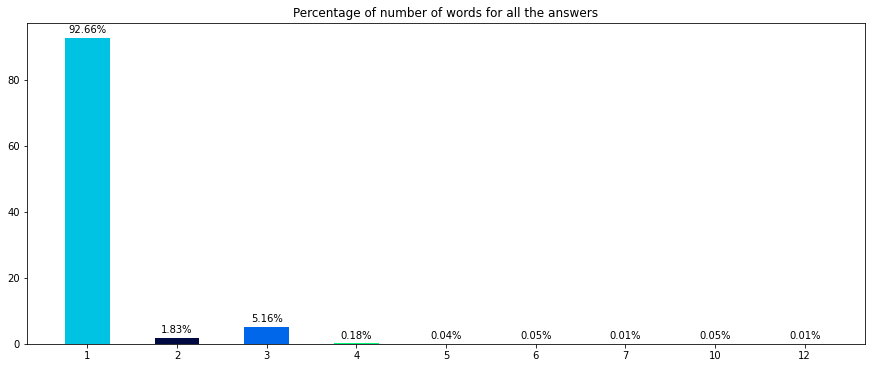

In [10]:
total_number_questions = train_VQA.n_tot
number_questions_more_one_word = train_VQA.n_mul
number_questions_one_word = total_number_questions - number_questions_more_one_word
## 1: Percentage of number of words for all the answers
columns = sorted([e+1 for e in list(train_VQA.c_len.keys())])
table_data = list(train_VQA.c_len.values())
table_data_percentage = []
table_data_percentage.append([(elem/total_number_questions)*100 for elem in table_data])
one_group_bar(columns, table_data_percentage, "Percentage of number of words for all the answers")

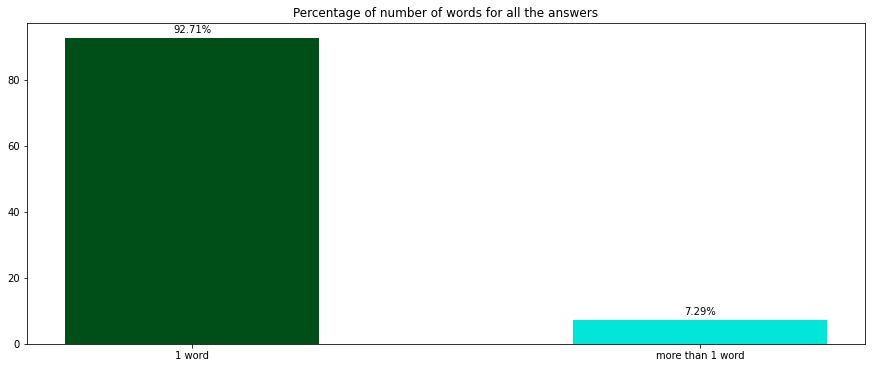

In [11]:
## 2: Percentage of number of words for all the answers
columns = ["1 word", "more than 1 word"]
table_data = [number_questions_one_word, number_questions_more_one_word]
table_data_percentage = []
table_data_percentage.append(
    [(elem/total_number_questions)*100 for elem in table_data])
one_group_bar(columns, table_data_percentage,
              "Percentage of number of words for all the answers")


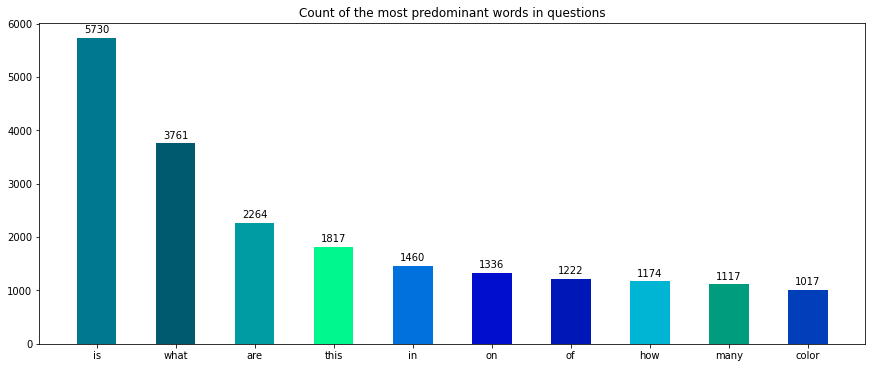

In [12]:
## 3: Count of the most predominant words in questions
q_most_common_words = qst_v.most_common(10)
columns = [e[0] for e in q_most_common_words]
table_data = [e[1] for e in q_most_common_words]
one_group_bar(columns, [table_data], "Count of the most predominant words in questions", False)

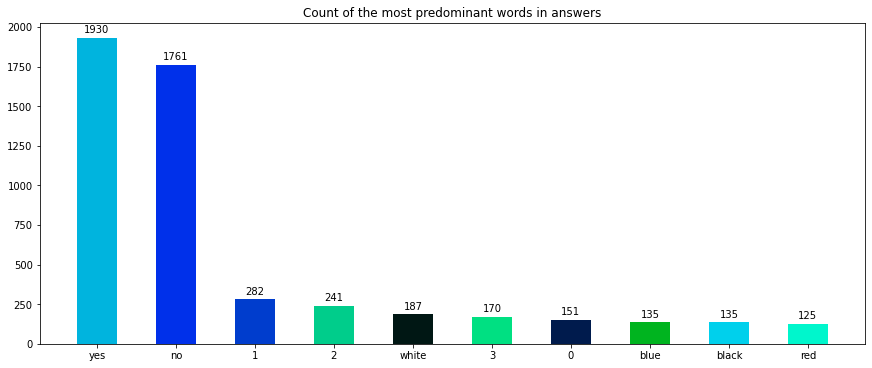

In [13]:
## 4: Count of the most predominant words in answers 
a_most_common_words = ans_v.most_common(10)
columns = [e[0] for e in a_most_common_words]
table_data = [e[1] for e in a_most_common_words]
table_data_percentage = []
table_data_percentage.append([(elem/total_number_questions)*100 for elem in table_data])
one_group_bar(columns, [table_data], "Count of the most predominant words in answers", False)

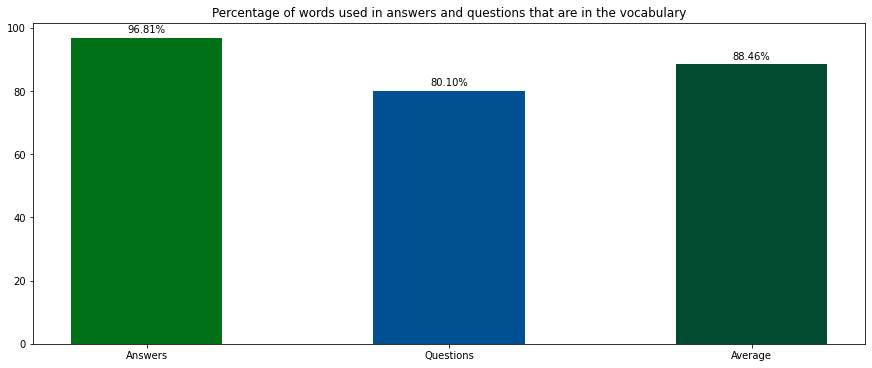

In [14]:
## 5: Percentage of words used in answers and questions that are in the vocabulary
l = [e[0] for e in ans_v.most_common(1000)]
number_words_in_most_common_ans = 0
for (_, ann) in list(train_VQA.qa.items()):
  if ann["multiple_choice_answer"] in l:
    number_words_in_most_common_ans += 1
l = [e[0] for e in qst_v.most_common(1000)]
number_words_in_most_common_qst = 0
total_number_words = 0
list(train_VQA.qqa.items())
for (_, qst) in list(train_VQA.qqa.items()):
  for w in qst["question"].split(" "):
    total_number_words += 1
    if w in l:
      number_words_in_most_common_qst += 1
column = ["Answers", "Questions", "Average"]
table_data = [number_words_in_most_common_ans, number_words_in_most_common_qst]
ans_value = number_words_in_most_common_ans/len(train_VQA.qa)
qst_value = number_words_in_most_common_qst/total_number_words
avg_v = (ans_value + qst_value) / 2
table_data_percentage = [ans_value*100, qst_value*100, avg_v*100]
one_group_bar(column, [table_data_percentage], "Percentage of words used in answers and questions that are in the vocabulary")

## Utilities

<img src='https://mistercode.it/wp-content/uploads/2022/05/to-do-g0a679a023_1280.png' width="200" height="100" > DESCRIBE WHY WE ARE USING SOME HPARAMS LIKE BATCH SIZE, LEARNING RATE AND Wd, TRAINABLE EMBEDDINGS, WHAT CHANGE IF WE KEEP IT FIXED?

In [15]:
# here we define the data class to collect all the hyperparameters of our models, these are the parameters 
# that do not change by the optimization problem solved at each training step. (at most they are adapted to) 
@dataclass
class HParams():
    # dataset stuff
    batch_size: int = 256
    n_cpu: int = 8
    qv_size: int = 1000 #+1 for oov +1 for pad
    av_size: int = 1000 #+1 for oov +1 for pad
    lr: int = 3e-4
    wd: int = 0
    word_emb_dim: int = 300 #output of the word-embedding
    lstm_hidden_dim: int = 512
    lstm_num_layers: int = 2
    output_dim: int = 1024
    bidirectional: bool = False
    dropout: float = 0.3
    trainable_embeddings: bool = True

hparams = asdict(HParams())

In [16]:
# this function implements the requested metric to evaluate our model
def evaluate_performances(model, data, on_train_set: bool, need_device: bool = True):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    dataset = data.train_dataloader() if on_train_set else data.val_dataloader()
    vqa = data.train_VQA if on_train_set else data.val_VQA
    # decode utility
    av_id2w = data.av_id2w
    it_data = iter(dataset)
    ans_types = Counter()
    scores = dict()
    for batch in tqdm(it_data):
        if need_device:
            batch["question"]=batch["question"].to(device)
            batch["img"]=batch["img"].to(device)
        pred = model.predict(batch)
        for id, pred in zip(pred["id"],pred["pred"]):
            ann = vqa.qa[id]
            ans_types.update([ann["answer_type"]])
            score = 0
            pred_ans = av_id2w.get(pred)
            for ans in ann["answers"]:
                answer = ans["answer"]
                if answer == pred_ans:
                    score+=1
                    # just for efficiency reasons
                    if score>2:
                        break
            scores[ann["answer_type"]] = scores.get(ann["answer_type"],0) + min([score/3,1])
    # print the final statisics
    print("There are: (type, number)")
    tot_q = 0
    tot_s = 0
    for k in ans_types:
        tot_q+=ans_types[k]
        print(k+" "+str(ans_types[k]))
        tot_s+=scores[k]
        print("with score: "+str(scores[k]/ans_types[k]))
    print("Final score: "+str(tot_s/tot_q))
    return ans_types, scores

In [17]:
# this function allow to show the prediction on a list of ids taken from the train/dev set
def print_item_pred(data, model, ids:list, on_train_set:bool, need_device: bool = True):
    dataset = data.train_dataloader() if on_train_set else data.val_dataloader()
    vqa = data.train_VQA if on_train_set else data.val_VQA
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    it_data = iter(dataset)
    av_id2w = data.av_id2w
    for batch in it_data:
        if len(ids)==0:
            break
        if need_device:
            batch["question"]=batch["question"].to(device)
            batch["img"]=batch["img"].to(device)
        pred = model.predict(batch)
        for id, pred in zip(pred["id"],pred["pred"]):
            if id in ids:
                ids.remove(id)
                question = vqa.qqa[id]["question"]
                answer = vqa.qa[id]["multiple_choice_answer"]
                img_id = vqa.qqa[id]["image_id"]
                img_pth = vqa.get_img_from_id(img_id)
                img = Image.open(img_pth).convert('RGB')
                plt.imshow(img)
                plt.axis('off')
                plt.show()
                print("QUESTION")
                print(question)
                print("MOST COMMON ANSWER")
                print(answer)
                print("PREDICTED ANSWER")
                print(av_id2w.get(pred))   

In [18]:
# this function is very helpful and allows to compare a list of models on a list of chosen metrics
def plot_multiple(metrics: List[str], models: List[str]):
    model_dict = dict()
    for model in models:
        metric_dict = dict()
        with open('logs/'+model+"/metrics.csv", mode='r') as csv_file:
            csv_reader = csv.DictReader(csv_file, delimiter=',')
            for row in csv_reader:
                # intersection between key of the dict and metric in metrics
                for k in [keys for keys in row.keys() if keys in metrics]:
                    if row[k] == '':
                        continue
                    metric_dict[k] = metric_dict.get(k,[])+[float(row[k])]
        model_dict[model] = metric_dict
    colors = dict()
    for metric in metrics:
        for model in model_dict:
            X=np.arange(len(model_dict[model][metric]))
            colors[model] = colors.get(model, [random.randrange(0, 255)/255, random.randrange(0, 255)/255, random.randrange(0, 255)/255, 1])
            plt.plot(X, model_dict[model][metric], color=colors[model], label=model)
        plt.xlabel("epoch")
        plt.ylabel(metric)
        plt.title("Comparison of different models for "+metric)
        plt.legend()
        plt.grid()
        plt.show()
    return model_dict

## Baseline

In the first part of our project we decided to implement [VQA: Visual Question Answering](https://arxiv.org/pdf/1505.00468.pdf) as a baseline. The aim of this part is to set a starting point that we will then compare to an advanced solution. The authors of the paper were among the first to tackle the problem of VQA thus we believe it's a good starting point for us.
<br>In the following cell we create the dataset exploiting the *vocabulary* previously createtd and the "*train_VQA.qa*" and "*train_VQA.qqa*" dictionaries. 
> In particular we build for each question the *item* <**question**, **image**, **answer**> for the training phase. 

<img src='https://mistercode.it/wp-content/uploads/2022/05/to-do-g0a679a023_1280.png' width="200" height="100" > DESCRIBE WHY WE NEED A TRAIN AND DEV SET AND WE CANNOT SIMPLY EVALUATE ON THE TRAINING.

In [23]:
class VQA_Dataset(Dataset):
    def __init__(self, VQA, qv_w2id, av_w2id):
        self.data = self.make_data(VQA, qv_w2id, av_w2id)

    def make_data(self, VQA, qv_w2id, av_w2id):
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            # https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html
            transforms.ToTensor(),
        ])
        data = list()
        qv_l = len(qv_w2id.keys())-2 #we remove oov and pad from the count
        av_l = len(av_w2id.keys())-2
        # efficient handling of the images
        imgs = dict()
        for k in VQA.qa:
            # we build for each question the item <qst, img, ans> for the training phase
            item = dict()
            item["id"] = k
            item["question"] = [qv_w2id.get(w, qv_l)
                             for w in VQA.qqa[k]['question'].split()]
            img_id = VQA.qqa[k]["image_id"]
            img_pth = VQA.get_img_from_id(img_id)
            imgs[img_id] = imgs.get(img_id, Image.open(img_pth).convert('RGB'))
            item["img"] = transform(imgs[img_id])
            # note that if the word is not in the vocabulary we set it as OOV (unknown)
            item["answer"] = av_w2id.get(VQA.qa[k]["multiple_choice_answer"], av_l)
            data.append(item)
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

class VQA_DataModule(pl.LightningDataModule):
    def __init__(self, hparams: dict, train_VQA: Any, val_VQA: Any, qv_w2id: dict, qv_id2w: dict, av_w2id: dict, av_id2w: dict) -> None:
        super().__init__()
        self.save_hyperparameters(hparams)
        self.train_VQA = train_VQA
        self.val_VQA = val_VQA
        self.qv_w2id = qv_w2id
        self.qv_id2w = qv_id2w
        self.av_w2id = av_w2id
        self.av_id2w = av_id2w

    def setup(self, stage: Optional[str] = None) -> None:
        self.data_train = VQA_Dataset(
            self.train_VQA, self.qv_w2id, self.av_w2id)
        self.data_val = VQA_Dataset(self.val_VQA, self.qv_w2id, self.av_w2id)

    def train_dataloader(self):
        return DataLoader(
            self.data_train,
            batch_size=self.hparams.batch_size,
            shuffle=True,
            num_workers=self.hparams.n_cpu,
            collate_fn=self.collate,
            pin_memory=True,
            persistent_workers=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.data_val,
            batch_size=self.hparams.batch_size,
            shuffle=False,
            num_workers=self.hparams.n_cpu,
            collate_fn=self.collate,
            pin_memory=True,
            persistent_workers=True
        )

    def collate(self, batch):
        batch_out = dict()
        batch_out["id"] = [sample["id"] for sample in batch]
        batch_out["answer"] = torch.as_tensor(
            [sample["answer"] for sample in batch])
        batch_out["img"] = torch.stack(
            [sample["img"] for sample in batch], dim=0)
        batch_out["question"] = pad_sequence(
            [torch.as_tensor(sample["question"]) for sample in batch],
            batch_first=True,
            padding_value=self.hparams.qv_size+1
        )
        return batch_out


In [24]:
# Creation of the data module 
data = VQA_DataModule(hparams, train_VQA, val_VQA, qv_w2id, qv_id2w, av_w2id, av_id2w)

### Architecture

**PAPER ARCHITECTURE**
![Architecture](https://imgur.com/vhOuMrh.jpg)
<br> The model consists in 2 different channels: an **image** channel and a **question** channel.<br>
Here the differenent components of our model

1.   **Image channel**<br>This channel provides an embedding for the *image*. In this part we used a ***VGG16*** pretrained network with feature extractor and first layers of the classifier freezed. One last FC layer is built on top so to obtain an output *1024-dim*.
2.   **Question channel**<br>This channel provides an embedding for the *question*. In particular we used an ***LSTM*** with two hidden layers (which gives an embedding of *2048-dim* for the question). One last FC layer is built on top to transform *2048-dim* embedding to *1024-dim*.
3.   **MLP** <br>The image and question embedding are fused via *element-wise multiplication* in order to obtain a single embedding. This *result embedding* is then feed to a fully connected layer of *1000-dim* output, which will make the  prediction about the  correct answer.

**CNN**
<br>Convolutional neural network have prove to be very efficient in image analysis. This comes from the fact that CNN are able to exploit priors of our image, such as:

*   Translation equivariance
*   Compositionality
*   Locality
*   Self similarity<br>


**LSTM**<br>
The basic architectures used to build a seq2seq model are RNNs, the general idea is that it takes as input a sequence of vectors $x_1, ..., x_n$ and an initial state vector $h_0$ and it returns a list of hidden/state vectors $h_1, ..., h_n$ and a list of output vectors $\hat{y}_1, ..., \hat{y}_n$ where each $\hat{y}_i$ is a function of the corresponding state vector $h_i$: a kind of memory of the previous $i$ inputs. To overcome the vanishing gradient problem of the basic architecture that would result in saturation of the state vectors during the backpropagation step, the authors decided to use the Long-Short Term Memory Networks (LSTM). 

<img src='https://mistercode.it/wp-content/uploads/2022/05/to-do-g0a679a023_1280.png' width="200" height="100" > DESCRIBE WHY ADAM, WHY THIS LOSS AND HOW WE MAKE THE FINAL PREDICTION (JUST THE MOST PROBABLE).

In [25]:
# this baseline comes from the paper "1505.00468", it uses lstm+cnn to predict the final one-word answer.
class VQA_Baseline(pl.LightningModule):
    def __init__(self, hparams: dict) -> None:
        super(VQA_Baseline, self).__init__()
        self.save_hyperparameters(hparams)
        self.cnn = models.vgg16(pretrained=True)
        # we freeze the features extractor of the cnn
        for params in self.cnn.features.parameters():
            params.requires_grad = False
        # we freeze the first layer of the classifier because has >102M params
        for params in self.cnn.classifier[0].parameters():
            params.requires_grad = False
        # we remove the last linear layer to be consistent with the authors
        self.cnn.classifier=self.cnn.classifier[:-1]
        self.mlp1 = nn.Linear(4096, self.hparams.output_dim) #1024
        self.word_emb = nn.Embedding(self.hparams.qv_size+2, self.hparams.word_emb_dim, padding_idx=self.hparams.qv_size+1)
        if not self.hparams.trainable_embeddings:
            for params in self.word_emb.parameters():
                params.requires_grad = False
        self.lstm = nn.LSTM(self.hparams.word_emb_dim, self.hparams.lstm_hidden_dim,
                            bidirectional = self.hparams.bidirectional,
                            num_layers = self.hparams.lstm_num_layers,
                            dropout = self.hparams.dropout if self.hparams.lstm_num_layers > 1 else 0,
                            batch_first = True,
                            )
        lstm_output_dim = self.hparams.lstm_hidden_dim if self.hparams.bidirectional is False else self.hparams.lstm_hidden_dim * 2
        lstm_emb_dim = 2*lstm_output_dim*self.hparams.lstm_num_layers
        self.dropout = nn.Dropout(self.hparams.dropout)
        self.mlp2 = nn.Linear(lstm_emb_dim, self.hparams.output_dim) #1024
        self.classifier = nn.Linear(self.hparams.output_dim, self.hparams.av_size)
    
    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        t_img = self.cnn(x["img"])
        # normalization with brodcasting
        norm = t_img.pow(2).sum(dim=1).sqrt()
        t_img = t_img/norm[:,None]
        img_emb = F.leaky_relu(self.mlp1(t_img), inplace=True)
        t_words = self.word_emb(x["question"])
        _, (h, c) = self.lstm(t_words)
        t_quest_tmp = torch.cat([c,h])
        t_quest = t_quest_tmp.reshape(t_quest_tmp.shape[1],-1)
        qst_emb = torch.tanh(self.mlp2(t_quest))
        q_i_emb = self.dropout(img_emb*qst_emb)
        return {"class_prob": self.classifier(q_i_emb), "id": x["id"]}
    
    def predict(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        n_out = dict()
        with torch.no_grad():
            output = self(x)
            n_out["pred"] = list(torch.argmax(output["class_prob"], dim=1).view(-1).cpu().detach().numpy())
            n_out["id"] = output["id"]
        return n_out
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr, betas=(0.9, 0.999), eps=1e-6, weight_decay=self.hparams.wd)
        reduce_lr_on_plateau = ReduceLROnPlateau(optimizer, mode='min',verbose=True, min_lr=1e-8)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": reduce_lr_on_plateau,
                "monitor": 'loss',
                "frequency": 1
            },
        }

    def training_step(self, batch: Dict[str, torch.Tensor], batch_idx) -> Dict[str, torch.Tensor]:
        output = self(batch)
        return self.loss_function(output, batch["answer"]) 

    def validation_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> Dict[str, torch.Tensor]:
        output = self(batch)
        loss = self.loss_function(output, batch["answer"])
        return {"loss_val": loss}

    def loss_function(self, predictions, labels):
        return F.cross_entropy(predictions["class_prob"], labels, ignore_index=self.hparams.av_size)

    def validation_epoch_end(self, outputs: List[Dict[str, torch.Tensor]]):
        avg_loss = torch.stack([x["loss_val"] for x in outputs]).mean()
        self.log_dict({"avg_val_loss": avg_loss})
        return {"avg_val_loss": avg_loss}
    
    def training_epoch_end(self, outputs: List[Dict[str, torch.Tensor]]):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.log_dict({"loss": avg_loss})

In [26]:
model = VQA_Baseline(hparams)

<img src='https://mistercode.it/wp-content/uploads/2022/05/to-do-g0a679a023_1280.png' width="200" height="100" > DESCRIBE WHY EARLY STOPPING IS USEFUL.

In [ ]:
experiment_name = "baseline"
log_version = "1"
logger = CSVLogger("logs", name=experiment_name, version=log_version)
epochs = 3
# f1 of argument classification, also possible eg 'avg_val_loss'
metric_to_monitor = "avg_val_loss"
mode = "min"  # you want to maximixe or minimize the metric?
early_stop_callback = EarlyStopping(
    monitor=metric_to_monitor, mode=mode, min_delta=0.00, patience=5, verbose=True)
    
checkpoint_callback = ModelCheckpoint(
    save_top_k=1,
    monitor=metric_to_monitor,
    mode=mode,
    dirpath="models",
    filename=experiment_name+"_"+log_version+"-{epoch:02d}-{loss:.4f}",
    verbose=True
)
# the trainer collect all the useful informations so far for the training
n_gpus = 1 if torch.cuda.is_available() else 0
trainer = pl.Trainer(logger=logger,
                     max_epochs=epochs,
                     log_every_n_steps=1,
                     gpus=n_gpus,
                     callbacks=[early_stop_callback, checkpoint_callback],
                     num_sanity_val_steps=0)

In [ ]:
trainer.fit(model, data)

In [ ]:
# est_ckpt = "models/baseline_0-epoch=29-loss=3.3660.ckpt"
# model = VQA_Baseline.load_from_checkpoint(best_ckpt, strict=False)
ans_types, scores = evaluate_performances(model, data, on_train_set=False)

In [ ]:
print_item_pred(data, model, [131366000], True)

In [ ]:
models_name = ["baseline/0", "baseline/bi-lstm"]
metrics = ["loss", "avg_val_loss"]
md = plot_multiple(metrics, models_name)

### **CONCLUSIONS ON THE BASELINE**
As shown from the evaluation this model achieves a final accuracy of **27%** on the validation set. By looking carefully the results we can see how only answers like "yes/no" are given correctly (>65%) while the performances are heavily penalized by "other" and "number" question types. Scoring so poorly we tried to improve the language model using a Bi-LSTM over the simple LSTM to attain better performances, but we got the same training trend.

This may not look good but it was actually a real breakthrough. The bottleneck of our network as one can expect is the CNN. Using VGG the model is not able to correctly learn specific features in an image (for instance to count objects), but it is able in some cases to answer easy questions which would require a yes/no answer; this subproblem can be seen as a classification task that our model is able to solve.

The main improvement that we'll propose will be a modified version of this CNN in which a region-proposal scheme is taken into account.

## ViLT: Vision-and-Language Transformer model

<img src='https://mistercode.it/wp-content/uploads/2022/05/to-do-g0a679a023_1280.png' width="200" height="100" > DESCRIBE WHY THIS ARCHITECTURE - THE DIFFERENT TYPES OF FEATURE EXTRACTORS, HOW IS BETTER THAN THE BASELINE AND POSSIBLE HPARAMS -- NEED TO ADD as HPARAMS DIFFERENT PREDICT STRATEGY (TOP K) , DIFFERENT EMBEDDING STRATEGY (EMBEED EVEN THE QUESTION TYPE) AND LOSS STRATEGY (DO NOT COUNT IT IF AT LEAST IN ONE OF THE ANSWER, EVEN IF NOT THE MOST COMMON)

At the start we wanted to implement LXMERT but it is very slow... todo

In [33]:
@dataclass
class HParams2():
    # dataset stuff
    batch_size: int = 256
    n_cpu: int = 8
    qv_size: int = 1000 #+1 for oov +1 for pad
    av_size: int = 1000 #+1 for oov +1 for pad
    lr: int = 3e-4
    wd: int = 0
    dropout: float = 0.3
    trainable_embeddings: bool = True
    prediction_strategy_top: int = 3 # choose the number of k to use a top-k prediction method
    embedding_strategy: str = "with_type" # choose between "simple" and "with_type"
    loss_strategy: str = "human_like" # choose between "simple" and "human_like"

<img src='https://mistercode.it/wp-content/uploads/2022/05/to-do-g0a679a023_1280.png' width="200" height="100" > DIFFERENCES WITH THE PREVIOUS SAMPLE

In [56]:
class VQA_Dataset2(Dataset):
    def __init__(self, VQA, av_w2id, embedding_strategy, loss_strategy):
        assert(embedding_strategy in ["simple","with_type"])
        assert(loss_strategy in ["simple","human_like"])
        self.data = self.make_data(VQA, av_w2id, embedding_strategy, loss_strategy)

    def make_data(self, VQA, av_w2id, embedding_strategy, loss_strategy):
        data = list()
        av_l = len(av_w2id.keys())-2  # we remove oov and pad from the count
        # efficient handling of the images
        imgs = dict()
        for k in VQA.qa:
            # we build for each question the item <qst, img, ans> for the training phase
            item = dict()
            item["id"] = k
            if embedding_strategy == "simple":
                item["question"] = VQA.qqa[k]['question']
            else:
                # we now embed together with the question, as "context" for the bert model inside ViLT, the "question_type" word,
                # the idea is that with this helpful information the language embedeer can point the attention to meaningful 
                # keywords like ["how" "many" ... "dogs"] insie a "number-type" question.
                item["question"] = [VQA.qqa[k]['question'], VQA.qa[k]["answer_type"]]
            img_id = VQA.qqa[k]["image_id"]
            img_pth = VQA.get_img_from_id(img_id)
            imgs[img_id] = imgs.get(img_id, Image.open(img_pth).convert('RGB'))
            item["img"] = imgs[img_id]
            if loss_strategy == "human_like":
                item["all_answers"] = [av_w2id.get(ans["answer"], av_l) for ans in VQA.qa[k]["answers"]]
            item["answer"] = av_w2id.get(
                VQA.qa[k]["multiple_choice_answer"], av_l)
            data.append(item)
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


class VQA_DataModule2(pl.LightningDataModule):
    def __init__(self, hparams: dict, train_VQA: Any, val_VQA: Any,
                 av_w2id: dict, av_id2w: dict) -> None:
        super().__init__()
        self.save_hyperparameters(hparams)
        self.train_VQA = train_VQA
        self.val_VQA = val_VQA
        self.av_w2id = av_w2id
        self.av_id2w = av_id2w

    def setup(self, stage: Optional[str] = None) -> None:
        self.data_train = VQA_Dataset2(
            self.train_VQA, self.av_w2id, self.hparams.embedding_strategy, self.hparams.loss_strategy)
        self.data_val = VQA_Dataset2(self.val_VQA, self.av_w2id, self.hparams.embedding_strategy, self.hparams.loss_strategy)

    def train_dataloader(self):
        return DataLoader(
            self.data_train,
            batch_size=self.hparams.batch_size,
            shuffle=True,
            num_workers=self.hparams.n_cpu,
            collate_fn=self.collate,
            pin_memory=True,
            persistent_workers=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.data_val,
            batch_size=self.hparams.batch_size,
            shuffle=False,
            num_workers=self.hparams.n_cpu,
            collate_fn=self.collate,
            pin_memory=True,
            persistent_workers=True
        )

    def collate(self, batch):
        batch_out = dict()
        batch_out["id"] = [sample["id"] for sample in batch]
        batch_out["answer"] = torch.as_tensor(
            [sample["answer"] for sample in batch])
        if self.hparams.loss_strategy == "human_like":
            batch_out["all_answers"] = [sample["all_answers"] for sample in batch]
        batch_out["img"] = [sample["img"] for sample in batch]
        batch_out["question"] = [sample["question"] for sample in batch]
        return batch_out


<img src='https://mistercode.it/wp-content/uploads/2022/05/to-do-g0a679a023_1280.png' width="200" height="100" > DESCRIPTION OF THE ARCHITECTURE EVEN HERE IF YOU WANT


In [86]:
class VQA_ViLT(pl.LightningModule):
    def __init__(self, hparams: dict) -> None:
        super(VQA_ViLT, self).__init__()
        self.save_hyperparameters(hparams)
        self.processor = ViltProcessor.from_pretrained(
            "dandelin/vilt-b32-finetuned-vqa")
        self.vilt = ViltModel.from_pretrained(
            "dandelin/vilt-b32-finetuned-vqa")
        for param in self.vilt.parameters():
            param.requires_grad = False
        if self.hparams.trainable_embeddings:
            #we can unfreeze only some layers due to limited gpu card memory.
            unfreeze = [10, 11]
            for i in unfreeze:
                for param in self.vilt.encoder.layer[i].parameters():
                    param.requires_grad = True
        self.dropout = nn.Dropout(self.hparams.dropout)
        self.classifier = nn.Sequential(
            nn.Linear(768, 1500),
            nn.ReLU(),
            self.dropout,
            nn.Linear(1500, self.hparams.av_size),
            nn.LeakyReLU())
        # self.classifier = nn.Linear(768, self.hparams.av_size)

    def forward(self, x):
        embeddings = self.processor(
            x["img"],
            x["question"],
            return_tensors="pt", padding=True).to(self.device)
        o = self.vilt(**embeddings).pooler_output
        if self.hparams.loss_strategy == "simple":
            return {"class_prob": self.classifier(self.dropout(o)), "id": x["id"]}
        else:
            return {"class_prob": self.classifier(self.dropout(o)), "id": x["id"], "all_answers": x["all_answers"]}

    def predict(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        n_out = dict()
        with torch.no_grad():
            output = self(x)
            # here we implement a top k prediction strategy with a given k as hyperparameter
            # if k = 1 we are simply using the argmax prediction as in the baseline
            top_k = torch.topk(
                output["class_prob"],
                self.hparams.prediction_strategy_top, dim=-1)
            # we need to normalize the "probabilities" (this step is not done at prediction time
            # because it is implicit in the crossentropy function, still we need to manually
            # apply it here)
            scores = F.softmax(top_k.values, dim=-1)
            # we sample only one element from the given "probability distribution" extracted with topk
            pred_id = torch.multinomial(scores, 1).view(-1).tolist()
            pred = top_k.indices[torch.arange(top_k.indices.size(0)), pred_id]
            n_out["pred"] = pred.view(-1).tolist()
            n_out["id"] = output["id"]
        return n_out

    def configure_optimizers(self):
        optimizer = optim.Adam(
            self.parameters(),
            lr=self.hparams.lr, betas=(0.9, 0.999),
            eps=1e-6, weight_decay=self.hparams.wd)
        reduce_lr_on_plateau = ReduceLROnPlateau(
            optimizer, mode='min', verbose=True, min_lr=1e-8)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": reduce_lr_on_plateau,
                "monitor": 'loss',
                "frequency": 1
            },
        }

    def training_step(self, batch: Dict[str, torch.Tensor],
                      batch_idx) -> Dict[str, torch.Tensor]:
        output = self(batch)
        return self.loss_function(output, batch["answer"])

    def validation_step(self, batch: Dict[str, torch.Tensor],
                        batch_idx: int) -> Dict[str, torch.Tensor]:
        output = self(batch)
        loss = self.loss_function(output, batch["answer"])
        return {"loss_val": loss}

    def loss_function(self, predictions, labels):
        pred, lab = predictions["class_prob"], labels
        if self.hparams.loss_strategy == "human_like":
            answers = torch.as_tensor(predictions["all_answers"]).to(self.device)
            most_prob = torch.argmax(predictions["class_prob"], dim=1).view(-1)
            filter = most_prob.unsqueeze(dim=1) == answers
            filter = torch.sum(filter.float(), dim=1)
            filter = filter < 1
            # if we have at least one answer inside the possible proposed by humans
            # we accept it as valid answer, and so we do not care about its loss!
            if not torch.all(filter==False):
                pred, lab = predictions["class_prob"][filter], labels[filter]
            else:
                print("our training is considered complete for this batch")
                return 0
        return F.cross_entropy(
            pred, lab, ignore_index=self.hparams.av_size)

    def validation_epoch_end(self, outputs: List[Dict[str, torch.Tensor]]):
        avg_loss = torch.stack([x["loss_val"] for x in outputs]).mean()
        self.log_dict({"avg_val_loss": avg_loss})
        return {"avg_val_loss": avg_loss}

    def training_epoch_end(self, outputs: List[Dict[str, torch.Tensor]]):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.log_dict({"loss": avg_loss})


In [87]:
hparams2 = asdict(HParams2())
data2 = VQA_DataModule2(hparams2, train_VQA, val_VQA, av_w2id, av_id2w)
model_vilt = VQA_ViLT(hparams2)

experiment_name = "ViLT"
log_version = "1"
logger = CSVLogger("logs", name=experiment_name, version=log_version)
epochs = 5
# we monitor and track avg_val_loss to save the best model and apply EarlyStopping
metric_to_monitor = "avg_val_loss"
mode = "min"  # you want to maximixe or minimize the metric?
early_stop_callback = EarlyStopping(
    monitor=metric_to_monitor, mode=mode, min_delta=0.00, patience=8, verbose=True)
checkpoint_callback = ModelCheckpoint(
    save_top_k=1,
    monitor=metric_to_monitor,
    mode=mode,
    dirpath="models",
    filename=experiment_name+"_"+log_version+"-{epoch:02d}-{loss:.4f}",
    verbose=True
)
# the trainer collect all the useful informations so far for the training
n_gpus = 1 if torch.cuda.is_available() else 0
trainer_vilt = pl.Trainer(logger=logger,
                     max_epochs=epochs,
                     log_every_n_steps=1,
                     gpus=n_gpus,
                     callbacks=[early_stop_callback, checkpoint_callback],
                     num_sanity_val_steps=0)

Some weights of the model checkpoint at dandelin/vilt-b32-finetuned-vqa were not used when initializing ViltModel: ['classifier.3.weight', 'classifier.3.bias', 'classifier.0.bias', 'classifier.0.weight', 'classifier.1.weight', 'classifier.1.bias']
- This IS expected if you are initializing ViltModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViltModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [88]:
trainer_vilt.fit(model_vilt,data2)

/home/dennis/Applications/anaconda3/envs/dlp/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /home/dennis/Desktop/Visual_QA_deep_learning/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | vilt       | ViltModel  | 111 M 
1 | dropout    | Dropout    | 0     
2 | classifier | Sequential | 2.7 M 
------------------------------------------
16.8 M    Trainable params
97.4 M    Non-trainable params
114 M     Total params
456.998   Total estimated model params size (MB)
/home/dennis/Applications/anaconda3/envs/dlp/lib/python3.9/site-packages/pytorch_lightning/loggers/csv_logs.py:57: UserWarning: Experiment logs directory logs/ViLT/1 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank

Epoch 0: 100%|██████████| 41/41 [04:17<00:00,  6.28s/it, loss=5.64, v_num=1]

Metric avg_val_loss improved. New best score: 5.626


Epoch 0: 100%|██████████| 41/41 [04:17<00:00,  6.28s/it, loss=5.64, v_num=1]

Epoch 0, global step 37: 'avg_val_loss' reached 5.62614 (best 5.62614), saving model to '/home/dennis/Desktop/Visual_QA_deep_learning/models/ViLT_1-epoch=00-loss=6.0894.ckpt' as top 1


Epoch 1: 100%|██████████| 41/41 [04:00<00:00,  5.86s/it, loss=5.67, v_num=1]

Metric avg_val_loss improved by 0.394 >= min_delta = 0.0. New best score: 5.232


Epoch 1: 100%|██████████| 41/41 [04:00<00:00,  5.86s/it, loss=5.67, v_num=1]

Epoch 1, global step 74: 'avg_val_loss' reached 5.23183 (best 5.23183), saving model to '/home/dennis/Desktop/Visual_QA_deep_learning/models/ViLT_1-epoch=01-loss=5.7395.ckpt' as top 1


Epoch 2: 100%|██████████| 41/41 [04:04<00:00,  5.96s/it, loss=5.64, v_num=1]

Metric avg_val_loss improved by 0.271 >= min_delta = 0.0. New best score: 4.961


Epoch 2: 100%|██████████| 41/41 [04:04<00:00,  5.96s/it, loss=5.64, v_num=1]

Epoch 2, global step 111: 'avg_val_loss' reached 4.96116 (best 4.96116), saving model to '/home/dennis/Desktop/Visual_QA_deep_learning/models/ViLT_1-epoch=02-loss=5.6963.ckpt' as top 1


Epoch 3:  29%|██▉       | 12/41 [01:15<03:02,  6.30s/it, loss=5.71, v_num=1]

/home/dennis/Applications/anaconda3/envs/dlp/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:724: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [89]:
ans_types2, scores2 = evaluate_performances(model_vilt, data2, on_train_set=False, need_device= False)
# if you repeat this on the train set you got the astonishing result of 95.93%

100%|██████████| 4/4 [00:22<00:00,  5.74s/it]


There are: (type, number)
other 465
with score: 0.296774193548387
yes/no 412
with score: 0.7613268608414239
number 123
with score: 0.35772357723577236
Final score: 0.49566666666666664


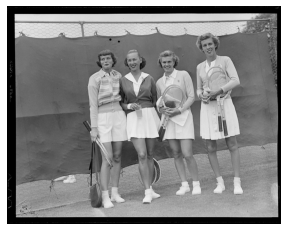

QUESTION
how many people are standing next to each other
MOST COMMON ANSWER
4
PREDICTED ANSWER
1


In [43]:
print_item_pred(data2, model_vilt, [131366000], on_train_set=True, need_device= False)

<img src='https://mistercode.it/wp-content/uploads/2022/05/to-do-g0a679a023_1280.png' width="200" height="100" > ALL THE EXPERIMENTS COLLECTED IN A TABLE AND DISCUSSION ABOUT THESE

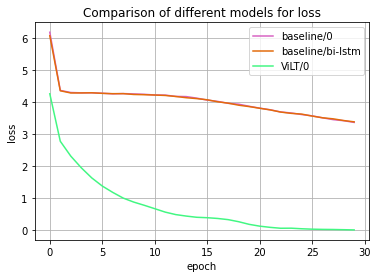

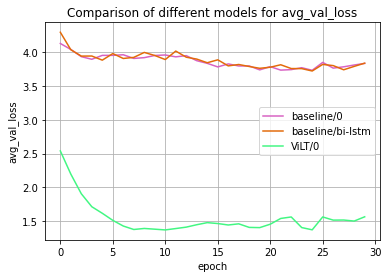

In [20]:
models_name = ["baseline/0", "baseline/bi-lstm", "ViLT/0"]
metrics = ["loss", "avg_val_loss"]
md = plot_multiple(metrics, models_name)